# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants
import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Init

In [3]:
import datahandler


dataset_id = "oslo"

data_preprocessor = datahandler.DataPreprocessorOUS(dataset_id)
data_preprocessor.execute()

data_loader = datahandler.DataLoader(dataset_id)
data_loader.execute()


Loading dataset: 100%|██████████| 6/6 [00:11<00:00,  2.00s/it]


In [4]:
import constants
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

COLOR_PALETTE = constants.COLOR_MAPPING_DEEP

# Plot

In [5]:
"""# Initialize figure
plt.figure(figsize=(10, 6))

df = data_loader.enhanced_incidents_df
triage_counts = df['triage_impression_during_call'].value_counts()

# Pre-filter data for each category and for response_time_sec < 10800
filtered_data = {cat: df[(df['triage_impression_during_call'] == cat) & (df['response_time_sec'] < 10800) & (df['response_time_sec'] > 0)]['response_time_sec'] for cat in triage_counts.index}

# Plot histogram for each category using the custom color palette
for cat in triage_counts.index:
    sns.histplot(filtered_data[cat], kde=False, label=cat, color=COLOR_PALETTE[cat])

# Add labels and title
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Response Times by Triage Category (< 10800 seconds)')
plt.legend(title='Categories')

# Show the plot
plt.show()"""

"# Initialize figure\nplt.figure(figsize=(10, 6))\n\ndf = data_loader.enhanced_incidents_df\ntriage_counts = df['triage_impression_during_call'].value_counts()\n\n# Pre-filter data for each category and for response_time_sec < 10800\nfiltered_data = {cat: df[(df['triage_impression_during_call'] == cat) & (df['response_time_sec'] < 10800) & (df['response_time_sec'] > 0)]['response_time_sec'] for cat in triage_counts.index}\n\n# Plot histogram for each category using the custom color palette\nfor cat in triage_counts.index:\n    sns.histplot(filtered_data[cat], kde=False, label=cat, color=COLOR_PALETTE[cat])\n\n# Add labels and title\nplt.xlabel('Response Time (seconds)')\nplt.ylabel('Frequency')\nplt.title('Distribution of Response Times by Triage Category (< 10800 seconds)')\nplt.legend(title='Categories')\n\n# Show the plot\nplt.show()"

In [6]:
"""# Initialize figure
plt.figure(figsize=(10, 6))

new_df = df
categories = ['Critical', 'High Priority']
# Pre-filter data for each category and for response_time_sec < 10800
filtered_data = {cat: new_df[(new_df['triage_impression_during_call'] == cat) & (new_df['response_time_sec'] < 8000) & (new_df['response_time_sec'] > 0)]['response_time_sec'] for cat in categories}

# Plot histogram for each category using the custom color palette
for cat in categories:
    sns.histplot(filtered_data[cat], kde=False, label=cat, color=COLOR_PALETTE[cat])

# Add labels and title
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Response Times by Triage Category (< 10800 seconds)')
plt.legend(title='Categories')

# Show the plot
plt.show()"""

"# Initialize figure\nplt.figure(figsize=(10, 6))\n\nnew_df = df\ncategories = ['Critical', 'High Priority']\n# Pre-filter data for each category and for response_time_sec < 10800\nfiltered_data = {cat: new_df[(new_df['triage_impression_during_call'] == cat) & (new_df['response_time_sec'] < 8000) & (new_df['response_time_sec'] > 0)]['response_time_sec'] for cat in categories}\n\n# Plot histogram for each category using the custom color palette\nfor cat in categories:\n    sns.histplot(filtered_data[cat], kde=False, label=cat, color=COLOR_PALETTE[cat])\n\n# Add labels and title\nplt.xlabel('Response Time (seconds)')\nplt.ylabel('Frequency')\nplt.title('Distribution of Response Times by Triage Category (< 10800 seconds)')\nplt.legend(title='Categories')\n\n# Show the plot\nplt.show()"

In [7]:
test_df = data_loader.processed_incidents_df

# Convert all time columns to datetime format
time_columns = [
    'time_call_received', 'time_call_processed', 'time_ambulance_notified',
    'time_dispatch', 'time_arrival_scene', 'time_departure_scene',
    'time_arrival_hospital', 'time_available'
]
# Initialize the figure
plt.figure(figsize=(18, 12))

# Loop through the columns and plot the distribution of "good" time differences
for i, (key, _) in enumerate(stats_dict_bad_values.items()):
    col1, col2 = key.split(" > ")
    
    # Calculate time difference for good values in seconds
    time_diff_series_bad = (df_sample[df_sample[col1] > df_sample[col2]][col2] - 
                             df_sample[df_sample[col1] > df_sample[col2]][col1]).dt.total_seconds()
    
    plt.subplot(3, 3, i + 1)
    sns.histplot(time_diff_series_bad, bins=50, kde=False)
    plt.title(f'Distribution of {key}')
    plt.xlabel('Time Difference (seconds)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

NameError: name 'stats_dict_bad_values' is not defined

<Figure size 1800x1200 with 0 Axes>

In [ ]:
# Sample code to check if there are any rows where time2 is before time1 in a DataFrame
test_df = data_loader.processed_incidents_df

# Initialize a dictionary to store counts of such instances for each pair of time columns
count_dict = {}
time_columns = [
    'time_call_received', 'time_call_processed', 'time_ambulance_notified',
    'time_dispatch', 'time_arrival_scene', 'time_departure_scene',
    'time_arrival_hospital', 'time_available'
]

# Loop through adjacent pairs of time columns to check
for i in range(len(time_columns) - 1):
    col1 = time_columns[i]
    col2 = time_columns[i + 1]
    
    # Count the number of rows where time2 is before time1
    count = len(test_df[test_df[col1] > test_df[col2]])
    
    # Store the count in the dictionary
    count_dict[f"{col2} before {col1}"] = count

count_dict

{'time_call_processed before time_call_received': 69700,
 'time_ambulance_notified before time_call_processed': 7688,
 'time_dispatch before time_ambulance_notified': 13,
 'time_arrival_scene before time_dispatch': 34,
 'time_departure_scene before time_arrival_scene': 2,
 'time_arrival_hospital before time_departure_scene': 2,
 'time_available before time_arrival_hospital': 34}

In [ ]:
# Convert all time columns to datetime format
time_columns = [
    'time_call_received', 'time_call_processed', 'time_ambulance_notified',
    'time_dispatch', 'time_arrival_scene', 'time_departure_scene',
    'time_arrival_hospital', 'time_available'
]
# Initialize the figure
plt.figure(figsize=(18, 12))


# Loop through the columns and plot the distribution of "good" time differences
for i, (key, _) in enumerate(stats_dict_bad_values.items()):
    col1, col2 = key.split(" > ")
    
    # Calculate time difference for good values in seconds
    time_diff_series_bad = (test_df[test_df[col1] > test_df[col2]][col2] - 
                             test_df[test_df[col1] > test_df[col2]][col1]).dt.total_seconds()
    
    plt.subplot(3, 3, i + 1)
    sns.histplot(time_diff_series_bad, bins=50, kde=False)
    plt.title(f'Distribution of {key}')
    plt.xlabel('Time Difference (seconds)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

NameError: name 'stats_dict_bad_values' is not defined

<Figure size 1800x1200 with 0 Axes>

In [ ]:
import pandas as pd
# Initialize a dictionary to keep the statistics for "good" datetime values
stats_dict_good_values = {}

df_sample = data_loader.enhanced_incidents_df

time_columns = [
    'time_call_received', 'time_call_processed', 'time_ambulance_notified',
    'time_dispatch', 'time_arrival_scene', 'time_departure_scene',
    'time_arrival_hospital', 'time_available'
]
df_sample[time_columns] = df_sample[time_columns].apply(pd.to_datetime, errors='coerce', format="%Y.%m.%dT%H:%M:%S")
        
# Loop through the columns and compare
for i in range(len(time_columns) - 1):
    col1 = time_columns[i]
    col2 = time_columns[i + 1]
    filtered_df_good = df_sample[df_sample[col1] <= df_sample[col2]]
    
    if not filtered_df_good.empty:
        # Calculate the time difference in seconds
        time_diff_series_good = (filtered_df_good[col2] - filtered_df_good[col1]).dt.total_seconds()
        
        # Calculate mean, median, and mode
        mean_time_diff_good = time_diff_series_good.mean()
        median_time_diff_good = time_diff_series_good.median()
        mode_time_diff_good = time_diff_series_good.mode()[0]  # Taking the first mode

        # Store the statistics in the dictionary
        stats_dict_good_values[f"{col1} <= {col2}"] = {
            'mean': mean_time_diff_good,
            'median': median_time_diff_good,
            'mode': mode_time_diff_good
        }

# Display the statistics for "good" datetime values
stats_dict_good_values

{'time_call_received <= time_call_processed': {'mean': 3262.421678955667,
  'median': 102.0,
  'mode': 45.0},
 'time_call_processed <= time_ambulance_notified': {'mean': 658.8536202315207,
  'median': 68.0,
  'mode': 4.0},
 'time_ambulance_notified <= time_dispatch': {'mean': 103.21219546948471,
  'median': 71.0,
  'mode': 4.0},
 'time_dispatch <= time_arrival_scene': {'mean': 583.5090119535205,
  'median': 476.0,
  'mode': 2.0},
 'time_arrival_scene <= time_departure_scene': {'mean': 1213.577041058083,
  'median': 1070.0,
  'mode': 2.0},
 'time_departure_scene <= time_arrival_hospital': {'mean': 1015.1713200955629,
  'median': 821.0,
  'mode': 2.0},
 'time_arrival_hospital <= time_available': {'mean': 1518.9536579109704,
  'median': 871.0,
  'mode': 2.0}}

## Histogram by Triage Level

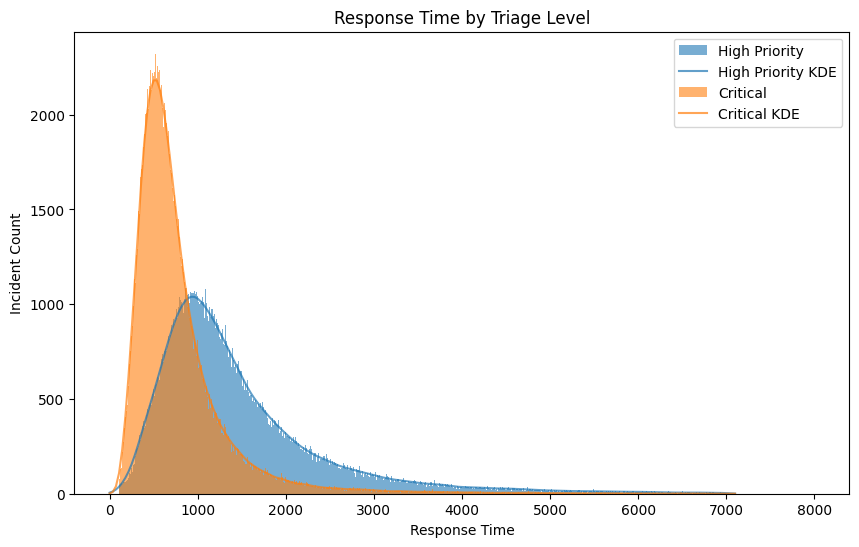

In [100]:
df = data_loader.enhanced_incidents_df

# Create the figure and axis objects
plt.figure(figsize=(10, 6))

colors = sns.color_palette()

# Color mapping
color_mapping = {
    'High Priority': colors[0],  # First color in the palette (usually blue)
    'Critical': colors[1]        # Second color in the palette (usually orange)
}
kde_color_mapping = {
    'High Priority': sns.dark_palette(colors[0], 3)[-1],  # Darker variant of the first color
    'Critical': sns.dark_palette(colors[1], 3)[-1]        # Darker variant of the second color
}

# Define bin range and bin width
bin_range = range(0, 8000, 6)
bin_width = bin_range[1] - bin_range[0]

# Loop through each unique Triage Level to plot its corresponding Response Time
for level in df['triage_impression_during_call'].unique():
    subset = df[df['triage_impression_during_call'] == level]
    
    # Plot the histogram
    plt.hist(subset['response_time_sec'], bins=bin_range, density=False, alpha=0.6, 
             label=level, color=color_mapping.get(level, 'grey'))
    
    # Compute and plot the KDE
    kde = gaussian_kde(subset['response_time_sec'])
    x_range = np.linspace(0, 7100, 200)
    plt.plot(x_range, kde(x_range) * len(subset) * bin_width, label=f"{level} KDE", color=kde_color_mapping.get(level, 'grey'), alpha=0.7)

# Add labels and title
plt.xlabel('Response Time')
plt.ylabel('Incident Count')
plt.title('Response Time by Triage Level')
plt.legend()

# Show the plot
plt.show()
